In [1]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import cv2

In [2]:
c = 1.0
epsilon0 = 1.0
mu_0 = 1.0 / (epsilon0 * c**2)
m_unit = 1.0
r_m = 1 / 25
m_electron = 1 * m_unit
m_ion = m_electron / r_m
t_r = 1.0 / 1.0
r_q = 1.0
n_e = 100 #ここは手動で調整すること
B0 = np.sqrt(n_e) / 1 / np.sqrt(2 / (1 + t_r))
n_i = int(n_e / r_q)
T_i  = (B0**2 / 2.0 / mu_0) / (n_i + n_e * t_r)
T_e = T_i * t_r
q_unit = np.sqrt(epsilon0 * T_e / n_e)
q_electron = -1 * q_unit
q_ion = r_q * q_unit
debye_length = np.sqrt(epsilon0 * T_e / n_e / q_electron**2)
omega_pe = np.sqrt(n_e * q_electron**2 / m_electron / epsilon0)
omega_pi = np.sqrt(n_i * q_ion**2 / m_ion / epsilon0)
omega_ce = q_electron * B0 / m_electron
omega_ci = q_ion * B0 / m_ion
ion_inertial_length = c / omega_pi
electron_inertial_length = c / omega_pe
sheat_thickness = 1.0 * ion_inertial_length
v_electron = np.array([0.0, 0.0, c * debye_length / sheat_thickness * np.sqrt(2 / (1.0 + 1 / t_r))])
v_ion = -v_electron / t_r
v_thermal_electron = np.sqrt(2.0 * T_e / m_electron)
v_thermal_ion = np.sqrt(2.0 * T_i / m_ion)
v_thermal_electron_background = np.sqrt(2.0 * T_e * 0.1 / m_electron)
v_thermal_ion_background = np.sqrt(2.0 * T_i * 0.1 / m_ion)
V_Ai = B0 / np.sqrt(mu_0 * n_i * m_ion)
V_Ae = B0 / np.sqrt(mu_0 * n_e * m_electron)
beta_e = n_e * T_e / (B0**2 / 2 / mu_0)
beta_i = n_i * T_i / (B0**2 / 2 / mu_0)
r_i = np.abs(m_ion * v_thermal_ion / q_ion / B0)
r_e = np.abs(m_electron * v_thermal_electron / q_electron / B0)

dx = 1.0
dy = 1.0
n_x = int(ion_inertial_length * 100.0)
n_y = int(ion_inertial_length * 50.0)
x_min = 0.0 * dx
y_min = 0.0 * dy
x_max = n_x * dx
y_max = n_y * dy
x_coordinate = np.arange(0.0, x_max, dx)
y_coordinate = np.arange(0.0, y_max, dy)
X, Y = np.meshgrid(x_coordinate, y_coordinate - y_max / 2.0)
dt = 0.5
step = 10000
t_max = step * dt

n_ion = int(n_x * n_i * 2.0 * sheat_thickness)
n_electron = int(n_ion * abs(q_ion / q_electron))
n_ion_background = int(n_x * n_y * 0.1 * n_i)
n_electron_background = int(n_x * n_y * 0.1 * n_e)
n_particle = n_ion + n_ion_background + n_electron + n_electron_background
print(f"total number of particles is {n_particle}.")
print(f"omega_pe = {omega_pe}, omega_ce = {omega_ce}")
print(f"box size is {n_x} X {n_y}")

total number of particles is 14000000.
omega_pe = 0.5, omega_ce = -0.5
box size is 1000 X 500


c:\Users\keita\anaconda3\Lib\site-packages\matplotlib\patches.py:3331: RuntimeWarning: invalid value encountered in scalar divide
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


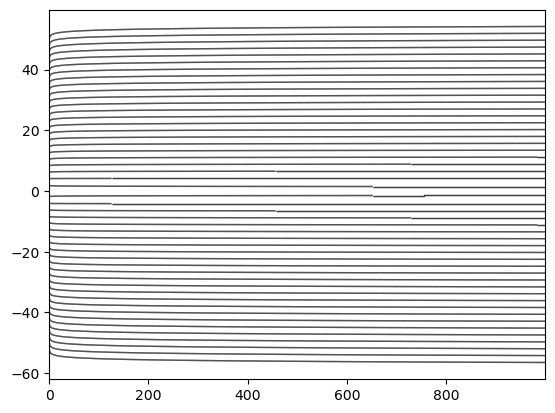

In [13]:
B = np.zeros([3, n_y, n_x])

bn = 0.1
gamma = 0.01
sheat_thickness = ion_inertial_length
mu = (1.0 + bn * X / gamma) ** (-gamma)
mu_prime = -bn * (1.0 + bn * X / gamma) ** (-gamma - 1.0)
B[0] =mu *  B0 * np.tanh(mu * Y / sheat_thickness)
B[1] = -mu_prime * B0 * Y * np.tanh(mu * Y / sheat_thickness) + mu_prime / mu 
B[2] = 0.0
A = B0 * sheat_thickness * (-np.log(np.cosh(mu * Y / sheat_thickness)) + np.log(mu / sheat_thickness))

start_y_enlarged = np.arange(-50, 50, 2)
start_points_enlarged = np.array([np.zeros(start_y_enlarged.shape), start_y_enlarged])
#plt.contourf(X, Y, A, levels=10)
#plt.quiver(X[::20], Y[::20], B[0][::20], B[1][::20], scale=5)
plt.streamplot(X, Y, B[0], B[1], broken_streamlines=False, 
               start_points=start_points_enlarged.T, color='black', density = 100, linewidth=1, arrowsize=0)
#plt.xlim(0, 200)
#plt.ylim(-200, 200)

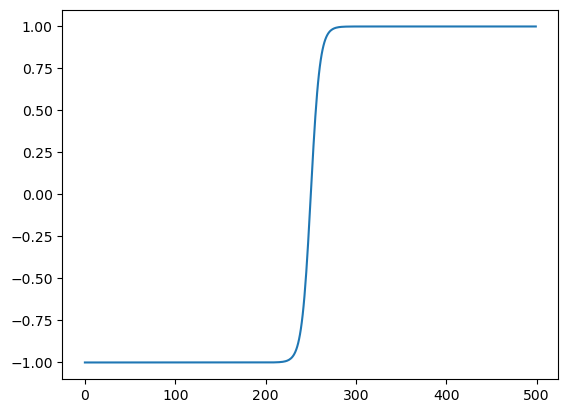

In [15]:
plt.plot(B[0, :, 0])

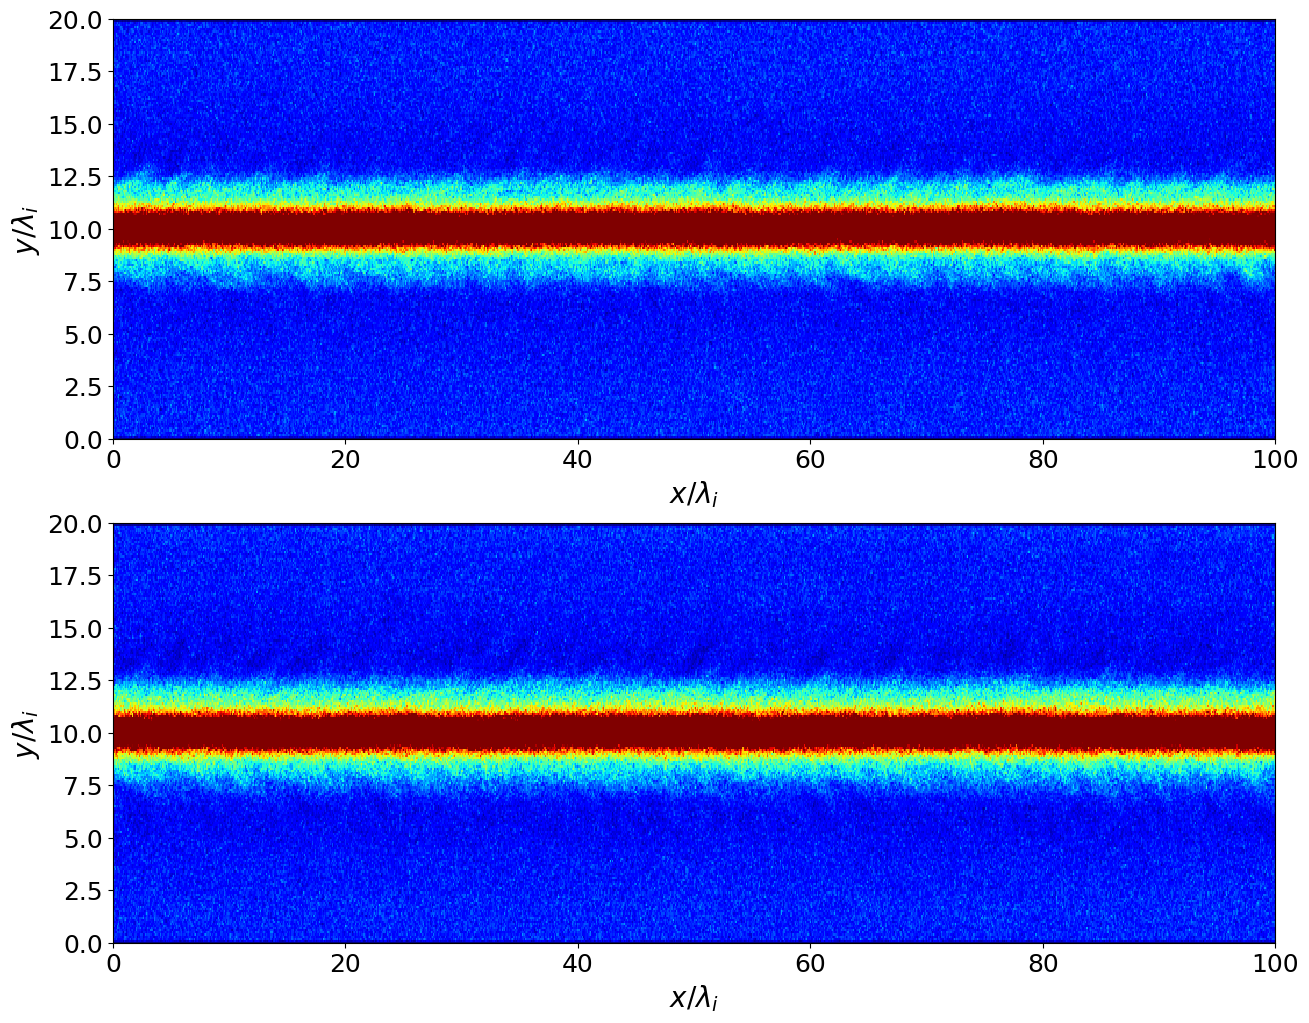

In [38]:
fig = plt.figure(figsize=(15, 12))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length

dirname = "results_tearing_By=0.1"
step = 2000
filename = f"{dirname}/tearing_By_zeroth_moment_ion_{step}.bin"
with open(filename, 'rb') as f:
    zeroth_moment_ion = np.fromfile(f, dtype=np.float32)
zeroth_moment_ion = zeroth_moment_ion.reshape(n_x, n_y).T
filename = f"{dirname}/tearing_By_zeroth_moment_electron_{step}.bin"
with open(filename, 'rb') as f:
    zeroth_moment_electron = np.fromfile(f, dtype=np.float32)
zeroth_moment_electron = zeroth_moment_electron.reshape(n_x, n_y).T

mappable = ax1.pcolormesh(X, Y, zeroth_moment_ion/n_i, cmap='jet', vmin=0, vmax=0.5)
ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
ax1.set_xlim(0.0, x_max/ion_inertial_length)
ax1.set_ylim(0, y_max/ion_inertial_length)
ax1.tick_params(labelsize=18)

mappable = ax2.pcolormesh(X, Y, zeroth_moment_electron/n_e, cmap='jet', vmin=0, vmax=0.5)
ax2.set_xlabel('$x / \lambda_i$', fontsize=20)
ax2.set_ylabel('$y / \lambda_i$', fontsize=20)
ax2.set_xlim(0.0, x_max/ion_inertial_length)
ax2.set_ylim(0, y_max/ion_inertial_length)
ax2.tick_params(labelsize=18)

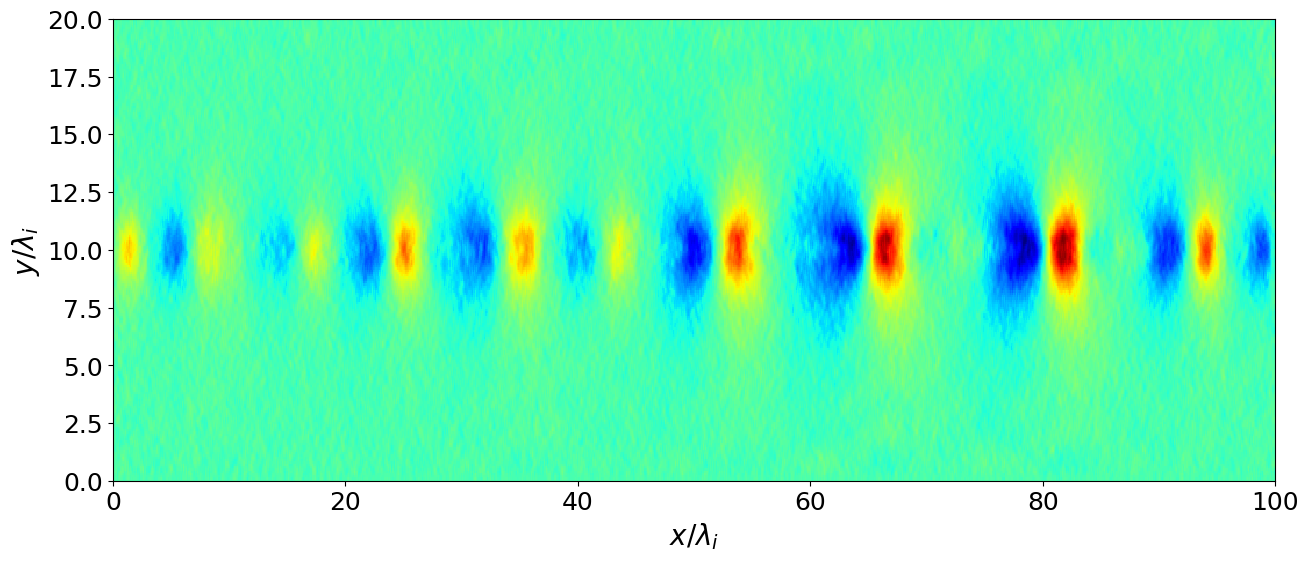

In [55]:
fig = plt.figure(figsize=(15, 6))
ax = fig.add_subplot(111)

X, Y = np.meshgrid(x_coordinate, y_coordinate) / ion_inertial_length

dirname = "results_tearing_By=0.01"
step = 2500
filename = f"{dirname}/tearing_By_B_{step}.bin"
with open(filename, 'rb') as f:
    B = np.fromfile(f, dtype=np.float32)
B = B.reshape(n_x, n_y, 3).T
filename = f"{dirname}/tearing_By_E_{step}.bin"
with open(filename, 'rb') as f:
    E = np.fromfile(f, dtype=np.float32)
E = E.reshape(n_x, n_y, 3).T

mappable = ax.pcolormesh(X, Y, cv2.blur(B[1, :, :], (3, 3)), cmap='jet')
ax.set_xlabel('$x / \lambda_i$', fontsize=20)
ax.set_ylabel('$y / \lambda_i$', fontsize=20)
ax.set_xlim(0.0, x_max/ion_inertial_length)
ax.set_ylim(0.0, y_max/ion_inertial_length)
ax.tick_params(labelsize=18)

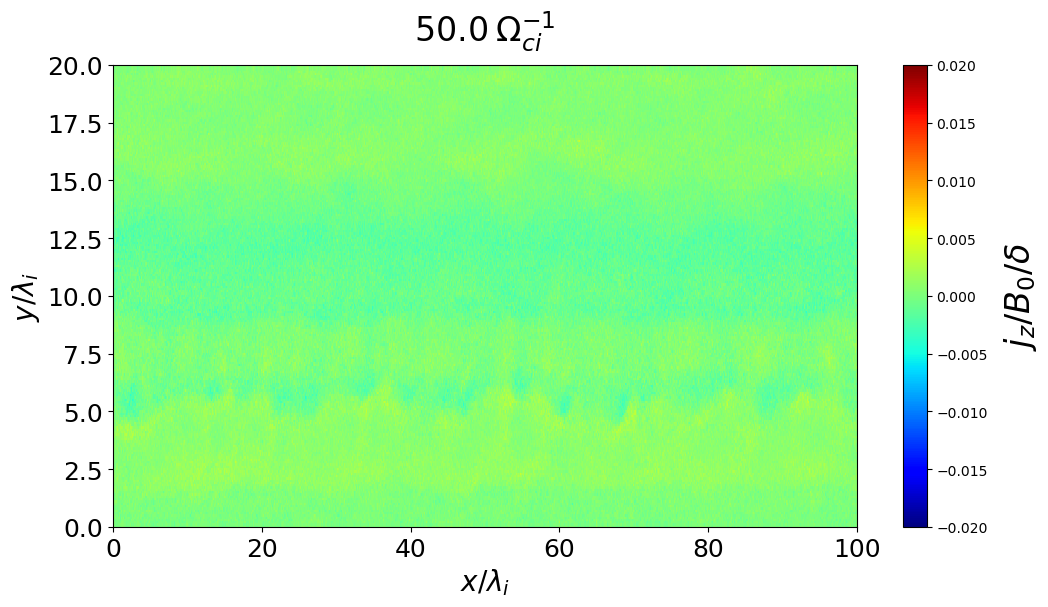

In [33]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)

interval = 100
total_steps = 5000
dirname = "results_tearing_By=0.1"

for step in range(0, total_steps+1, interval):
    ax1.clear()

    filename = f"{dirname}/tearing_By_current_{step}.bin"
    with open(filename, 'rb') as f:
        current = np.fromfile(f, dtype=np.float32)
    current = current.reshape(n_x, n_y, 3).T

    mappable = ax1.pcolormesh(X, Y, current[2] / B0 / sheat_thickness, cmap='jet', vmin=-0.02, vmax=0.02)
    if step == 0:
        cbar = plt.colorbar(mappable, ax=ax1)
        cbar.set_label(r"$j_z / B_0 / \delta$", fontsize=24, rotation=90, labelpad=10)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=18)
    ax1.text(0.5, 1.05, f"{step/(1.0/omega_ci/dt):.1f}" + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=24)

    fig.savefig(f"pictures/{step}.png", dpi=200)


filename = "tearing_jz_By=0.1.mp4"
img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(interval, total_steps+interval, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()

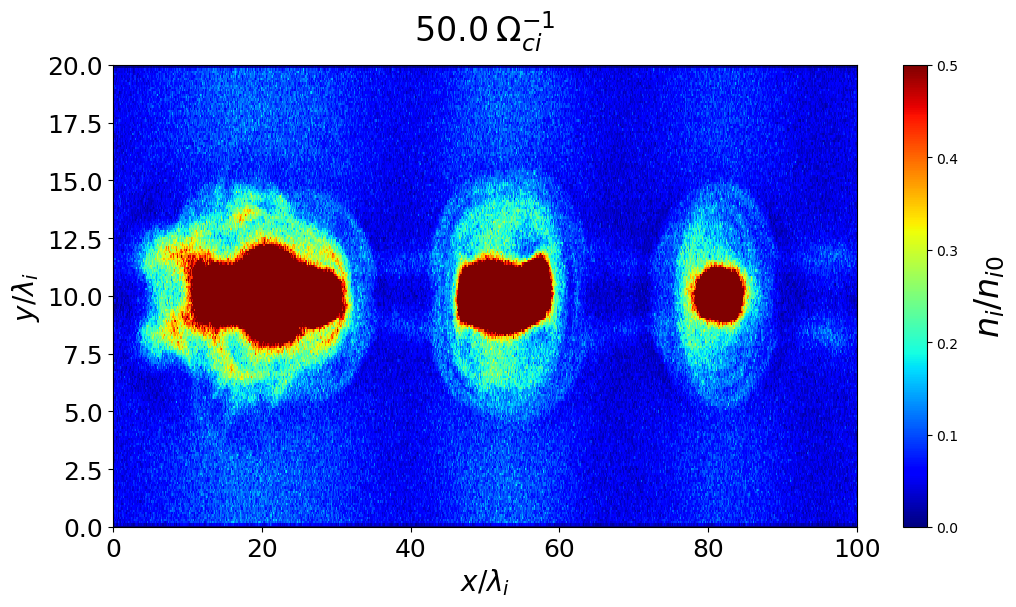

In [40]:
fig = plt.figure(figsize=(12, 6))
ax1 = fig.add_subplot(111)

interval = 100
total_steps = 5000
dirname = "results_tearing_By=0.01"

for step in range(0, total_steps+1, interval):
    ax1.clear()

    filename = f"{dirname}/tearing_By_zeroth_moment_ion_{step}.bin"
    with open(filename, 'rb') as f:
        zeroth_moment_ion = np.fromfile(f, dtype=np.float32)
    zeroth_moment_ion = zeroth_moment_ion.reshape(n_x, n_y).T

    mappable = ax1.pcolormesh(X, Y, zeroth_moment_ion / n_i, cmap='jet', vmin=0.0, vmax=0.5)
    if step == 0:
        cbar = plt.colorbar(mappable, ax=ax1)
        cbar.set_label(r"$n_i / n_{i0}$", fontsize=24, rotation=90, labelpad=10)
    ax1.set_xlabel('$x / \lambda_i$', fontsize=20)
    ax1.set_ylabel('$y / \lambda_i$', fontsize=20)
    ax1.set_xlim(0.0, x_max/ion_inertial_length)
    ax1.set_ylim(0, y_max/ion_inertial_length)
    ax1.tick_params(labelsize=18)
    ax1.text(0.5, 1.05, f"{step/(1.0/omega_ci/dt):.1f}" + r"$ \: \Omega_{ci}^{-1}$", ha='center', transform=ax1.transAxes, fontsize=24)

    fig.savefig(f"pictures/{step}.png", dpi=200)


filename = "tearing_ni_By=0.01.mp4"
img = cv2.imread(f'./pictures/0.png')
framesize = (img.shape[1], img.shape[0])
fps = 5.0
fourcc = cv2.VideoWriter_fourcc('m','p','4','v')
video  = cv2.VideoWriter(filename=filename, fourcc=fourcc, fps=fps, frameSize=framesize)

for step in range(interval, total_steps+interval, interval):
    img = cv2.imread(f'./pictures/{step}.png')
    video.write(img)
video.release()

##################################################

In [25]:
total_steps = 10000
interval = 100
num_results = int(total_steps/interval) + 1
kinetic_energy = np.zeros(num_results)
electric_field_energy = np.zeros(num_results)
magnetic_field_energy = np.zeros(num_results)
t = np.arange(0.0, (total_steps+1)*dt, interval*dt)

dirname = "results_tearing"
for step in range(0, total_steps+1, interval):
    filename = f"{dirname}/tearing_KE_{step}.bin"
    with open(filename, 'rb') as f:
        KE = np.fromfile(f, dtype=np.float32)
    filename = f"{dirname}/tearing_EEnergy_{step}.bin"
    with open(filename, 'rb') as f:
        EEnergy = np.fromfile(f, dtype=np.float32)
    filename = f"{dirname}/tearing_BEnergy_{step}.bin"
    with open(filename, 'rb') as f:
        BEnergy = np.fromfile(f, dtype=np.float32)
    kinetic_energy[int(step/interval)] = KE
    electric_field_energy[int(step/interval)] = EEnergy
    magnetic_field_energy[int(step/interval)] = BEnergy

total_energy = kinetic_energy + electric_field_energy + magnetic_field_energy
print(total_energy[-1] / total_energy[0])

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111)
ax.plot(t, kinetic_energy, label='Kinetic Energy')
ax.plot(t, electric_field_energy, label='Electric Field Energy')
ax.plot(t, magnetic_field_energy, label='Magnetic Field Energy')
ax.plot(t, total_energy, label='Total Energy', ls='--')
ax.legend(loc='best', fontsize=18)
ax.set_xlim(0.0, total_steps*dt)
ax.tick_params(labelsize=20)
fig.savefig("tearing_energy.png")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'results_tearing/tearing_KE_0.bin'

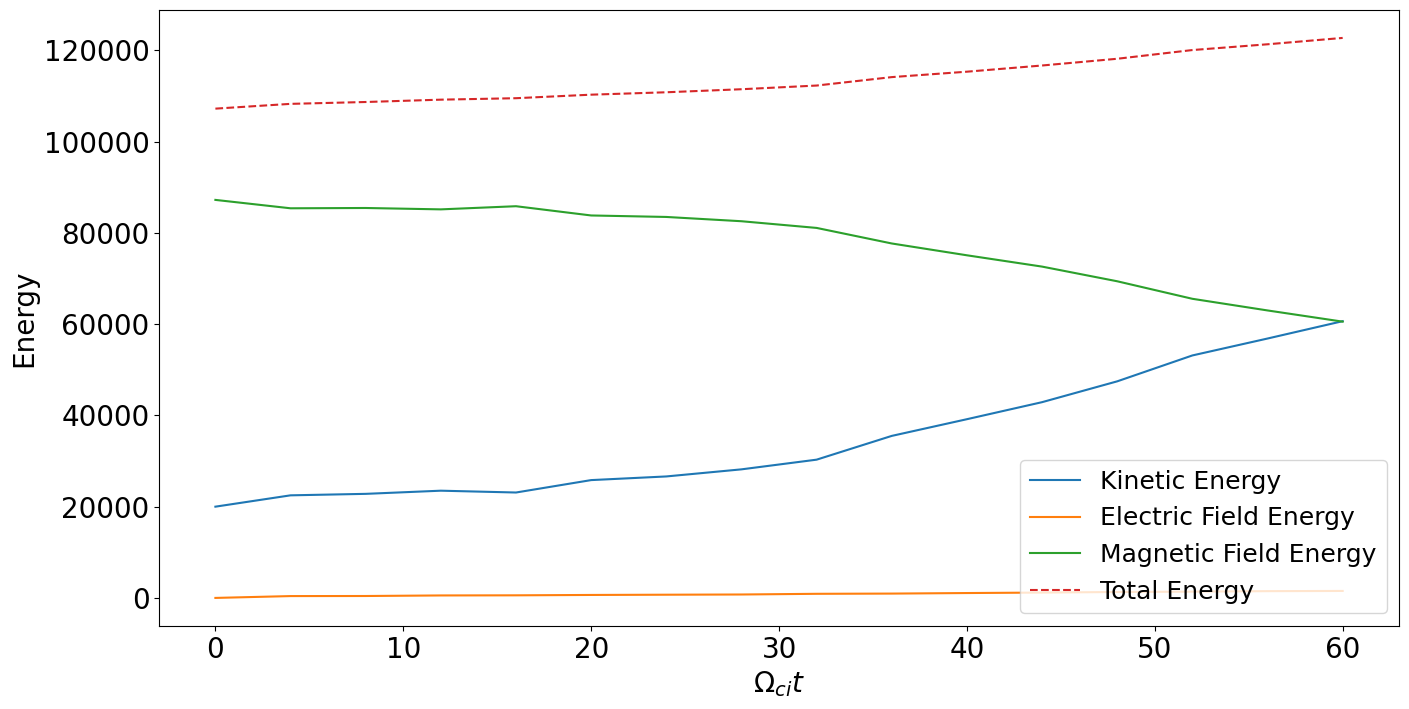

In [32]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_subplot(111)
ax.plot(t*omega_ci, kinetic_energy, label='Kinetic Energy')
ax.plot(t*omega_ci, electric_field_energy, label='Electric Field Energy')
ax.plot(t*omega_ci, magnetic_field_energy, label='Magnetic Field Energy')
ax.plot(t*omega_ci, total_energy, label='Total Energy', ls='--')
ax.legend(loc='lower right', fontsize=18)
#ax.set_ylim(1e5)
#ax.set_xlim(0.0, number_of_results*5000*omega_ci)
ax.set_xlabel('$\Omega_{ci} t$', fontsize=20)
ax.set_ylabel('Energy', fontsize=20)
ax.tick_params(labelsize=20)
plt.show()
fig.savefig('test.png')

線形成長率について

In [47]:
dirname = "results_tearing_By=0.01"
log = np.loadtxt(f"{dirname}/log_tearing_By.txt", delimiter=',')
By_FFT_total = np.zeros([51, n_x])
total_steps = int(log[-1])
interval = 100

t = np.zeros(51)

for step in range(0, total_steps+interval, interval):
    t[int(step/interval)] = float(log[int(step/interval)])

    filename = f"{dirname}/tearing_By_B_{step}.bin"
    with open(filename, 'rb') as f:
        B = np.fromfile(f, dtype=np.float32)
    B = B.reshape(n_x, n_y, 3).T

    By_FFT_total[int(step/interval), :] = np.fft.fft(B[1, int(n_y / 2), :] * np.hanning(n_x))

C:\Users\keita\AppData\Local\Temp\ipykernel_4680\1343500137.py:17: ComplexWarning: Casting complex values to real discards the imaginary part
  By_FFT_total[int(step/interval), :] = np.fft.fft(B[1, int(n_y / 2), :] * np.hanning(n_x))


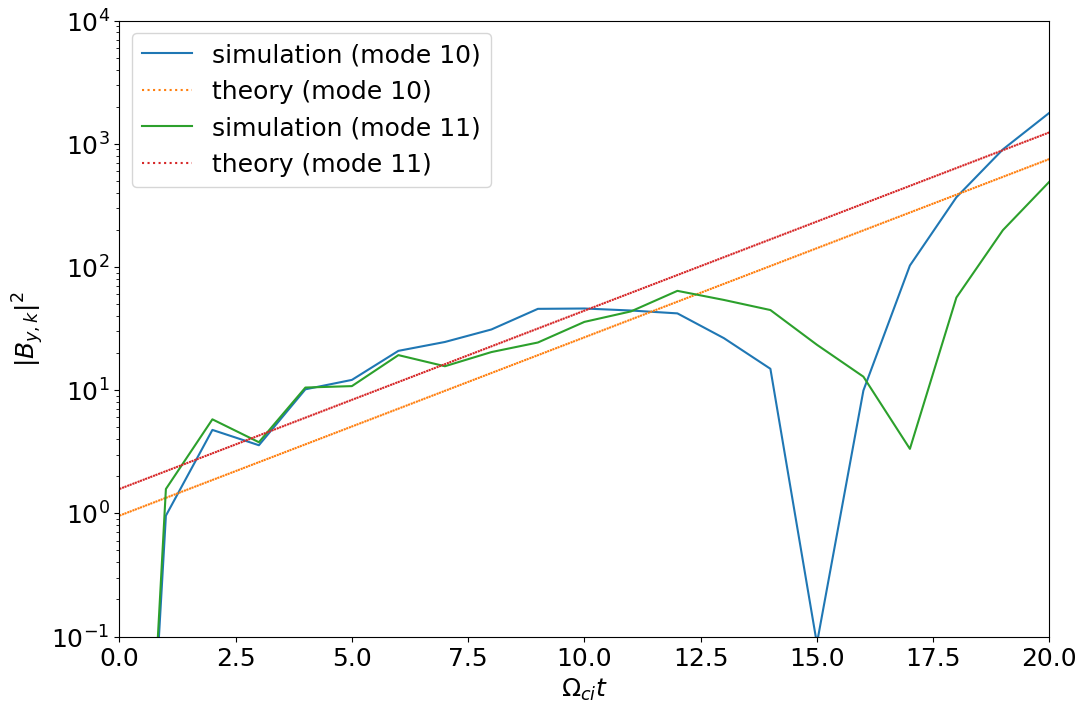

In [61]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(111)

peak_index = np.argsort(np.abs(By_FFT_total[25, :int(n_x/2)]))[-2:]
growth_rate = np.sqrt(np.pi) * (1.0 + t_r) * (r_e / sheat_thickness)**2.5 * np.abs(omega_ce)

for i in np.sort(peak_index):
    ax1.plot(omega_ci * t, np.abs(By_FFT_total[:, i])**2, label=f"simulation (mode {i})") 
    ax1.plot(omega_ci * t, np.abs(By_FFT_total[1, i])**2 * np.exp(1/2 * growth_rate * t), ls='dotted', label=f"theory (mode {i})")

ax1.set_yscale('log')
ax1.set_xlabel(r'$\Omega_{ci}t$', fontsize=18)
ax1.set_ylabel('$|B_{y, k}|^2$', fontsize=18)
ax1.set_xlim(0, 20)
ax1.set_ylim(1e-1, 1e4)
ax1.tick_params(labelsize=18)
ax1.legend(loc="upper left", fontsize=18)
fig.savefig("collisionless_electron_tering_By=0.01_growth_rate.png")